In [328]:
import torch
from torchvision import transforms
import beacon
from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import ParabolaGen
import NoiseGen

In [329]:
x_dim = 90
y_dim = 120
time_dimension = 1000
num_of_files = 1
origin = None    #Set to none to have random origins, or input coordinates (x,y, ToF)

train_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 128, origin).unsqueeze(1)
test_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 32, origin).unsqueeze(1)

In [330]:
train_data_noised = (NoiseGen.generate_gaussian_noise(128, 120, 90, mean=300, std=50) + NoiseGen.generate_binary_noise(128, 120, 90, magnitude=300)).unsqueeze(1) + train_data
test_data_noised = (NoiseGen.generate_gaussian_noise(32, 120, 90, mean=100, std=50) + NoiseGen.generate_binary_noise(32, 120, 90, magnitude=300)).unsqueeze(1) + test_data

trainloader = torch.utils.data.DataLoader((train_data_noised, train_data), batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader((test_data_noised, test_data), batch_size=16, shuffle=False)

In [331]:
train_data_noised.shape

torch.Size([128, 1, 120, 90])

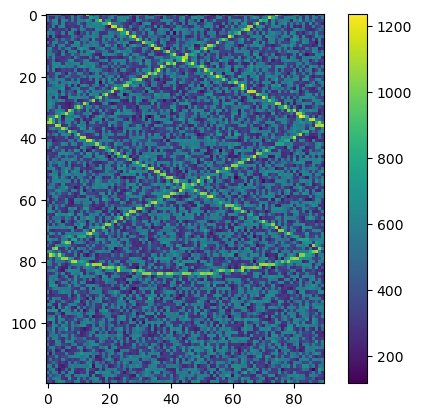

In [332]:
plt.imshow(train_data_noised[0][0])
plt.colorbar()

In [333]:
class LinearAutoencoder(beacon.Module):
    def __init__(self, input_features):
        super().__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 16),
            torch.nn.ReLU()
        )
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, input_features),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [334]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, 3, stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 3, stride=1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [335]:
summary(ConvolutionAutoencoder(), input_size=(1, 1, 120, 90))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [1, 1, 120, 90]           --
├─Sequential: 1-1                        [1, 64, 114, 84]          --
│    └─Conv2d: 2-1                       [1, 16, 118, 88]          160
│    └─BatchNorm2d: 2-2                  [1, 16, 118, 88]          32
│    └─ReLU: 2-3                         [1, 16, 118, 88]          --
│    └─Conv2d: 2-4                       [1, 32, 116, 86]          4,640
│    └─BatchNorm2d: 2-5                  [1, 32, 116, 86]          64
│    └─ReLU: 2-6                         [1, 32, 116, 86]          --
│    └─Conv2d: 2-7                       [1, 64, 114, 84]          18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 114, 84]          128
│    └─ReLU: 2-9                         [1, 64, 114, 84]          --
├─Sequential: 1-2                        [1, 1, 120, 90]           --
│    └─ConvTranspose2d: 2-10             [1, 32, 116, 86]          18,464
│ 

In [336]:
autoencoder = ConvolutionAutoencoder().to("mps")
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.005)

In [337]:
for epoch in tqdm(range(10)):
    for input_images, target_images in trainloader:
        optimiser.zero_grad()
        outputs = autoencoder(input_images.to("mps"))
        loss = loss_function(outputs, target_images.to("mps"))
        loss.backward()
        optimiser.step()

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


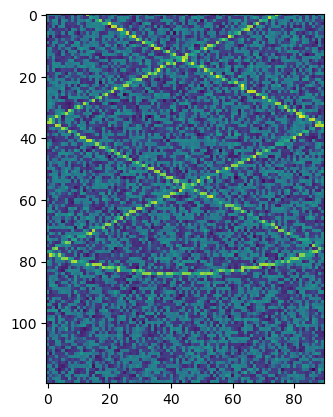

In [338]:
plt.imshow(train_data_noised[0][0])

In [339]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(train_data[0].unsqueeze(0).to("cpu"))

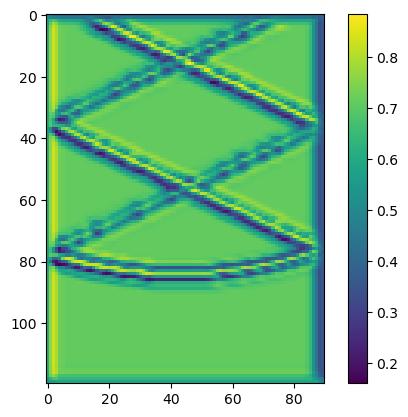

In [340]:
plt.imshow(pred[0][0].cpu())
plt.colorbar()

In [342]:
train_data[0][0].dot(pred[0][0])

RuntimeError: 1D tensors expected, but got 2D and 2D tensors